In [1]:
#!pip install -U scikit-learn scipy matplotlib

In [2]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import os
import itertools


In [3]:
iou_treshold = 0.5
IMAGE_WIDTH = 2464
IMAGE_HEIGHT = 2056
GROUND_TRUTH_DIRECTORY = '/cluster/home/solveijm/hurtigruten/'

PREDICTED_PATH = '../../runs/detect/test_1cls_100e_640imgsz_terminal/labels/'

# Load ground truth and predicted

In [4]:
test_image_paths = os.path.join(GROUND_TRUTH_DIRECTORY, 'test.txt')
with open(test_image_paths, 'r') as f:
    test_image_filenames = [line.strip().split('/')[-1].split('.')[0] for line in f.readlines()]

ground_truth_annot_paths = [f'{GROUND_TRUTH_DIRECTORY}/labels/{name}.txt' for name in test_image_filenames]

predicted_annot_paths = [os.path.join(PREDICTED_PATH, filename) for filename in os.listdir(PREDICTED_PATH)]


# Calculate confusion matrix

In [5]:
def read_annotations_yolo(annotations_path):
    annotations = []
    with open(annotations_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])
            x1 = int((x_center - width / 2) * IMAGE_WIDTH)
            y1 = int((y_center - height / 2) * IMAGE_HEIGHT)
            x2 = int((x_center + width / 2) * IMAGE_WIDTH)
            y2 = int((y_center + height / 2) * IMAGE_HEIGHT)
            annotations.append({
                'class_id': class_id,
                'x1': x1,
                'y1': y1,
                'x2': x2,
                'y2': y2
            })
    return annotations

In [6]:
def compute_iou(annot1, annot2):
    """
    Compute the IoU between two bounding boxes.
    
    Arguments:
    annot1 -- a dict of {class_id: int, x1: float, y1: float, x2: float, y2: float} representing the coordinates of the first bounding box
    annot2 -- a dict of {class_id: int, x1: float, y1: float, x2: float, y2: float} representing the coordinates of the second bounding box
    
    Returns:
    iou -- the IoU between the two bounding boxes
    """
    # Calculate the intersection area
    x_left = max(annot1['x1'], annot2['x1'])
    y_top = max(annot1['y1'], annot2['y1'])
    x_right = min(annot1['x2'], annot2['x2'])
    y_bottom = min(annot1['y2'], annot2['y2'])

    if x_right < x_left or y_bottom < y_top:
        intersection_area = 0
    else:
        intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Calculate the union area
    annot1_area = (annot1['x2'] - annot1['x1']) * (annot1['y2'] - annot1['y1'])
    annot2_area = (annot2['x2'] - annot2['x1']) * (annot2['y2'] - annot2['y1'])
    union_area = annot1_area + annot2_area - intersection_area

    # Calculate the IoU
    iou = intersection_area / union_area

    return iou

In [7]:
# Load the ground truth and predicted bounding boxes

def get_filenam(path):
    return path.strip().split('/')[-1].split('.')[0]

ground_truth_annots = {get_filenam(image): read_annotations_yolo(image) for image in ground_truth_annot_paths}
predicted_detections = {get_filenam(image): read_annotations_yolo(image) for image in predicted_annot_paths}

In [8]:
ground_truth_annots

{'00000713': [{'class_id': 0, 'x1': 93, 'y1': 846, 'x2': 161, 'y2': 912},
  {'class_id': 0, 'x1': 257, 'y1': 905, 'x2': 310, 'y2': 975},
  {'class_id': 0, 'x1': 1763, 'y1': 689, 'x2': 1833, 'y2': 772},
  {'class_id': 0, 'x1': 1944, 'y1': 697, 'x2': 1984, 'y2': 729},
  {'class_id': 0, 'x1': 974, 'y1': 740, 'x2': 1008, 'y2': 782},
  {'class_id': 0, 'x1': 1057, 'y1': 667, 'x2': 1090, 'y2': 695},
  {'class_id': 0, 'x1': 1107, 'y1': 610, 'x2': 1125, 'y2': 631},
  {'class_id': 0, 'x1': 844, 'y1': 610, 'x2': 863, 'y2': 631},
  {'class_id': 0, 'x1': 346, 'y1': 648, 'x2': 374, 'y2': 684},
  {'class_id': 0, 'x1': 470, 'y1': 708, 'x2': 496, 'y2': 753},
  {'class_id': 0, 'x1': 523, 'y1': 606, 'x2': 544, 'y2': 638},
  {'class_id': 0, 'x1': 512, 'y1': 580, 'x2': 523, 'y2': 593},
  {'class_id': 0, 'x1': 415, 'y1': 606, 'x2': 440, 'y2': 627},
  {'class_id': 0, 'x1': 487, 'y1': 585, 'x2': 501, 'y2': 602},
  {'class_id': 0, 'x1': 481, 'y1': 604, 'x2': 497, 'y2': 617},
  {'class_id': 0, 'x1': 705, 'y1': 

In [9]:

def compute_confusion_matrix(ground_truth_annots, predicted_detections, iou_threshold):
    # Compute the number of true positives, false positives, and false negatives
    tp = 0
    fp = 0
    fn = 0
    for image, gt_annotations in ground_truth_annots.items():
        for gt_annot in gt_annotations:
            found_match = False
            if image in predicted_detections.keys():
                for pred_annot in predicted_detections[image]:
                    iou = compute_iou(gt_annot, pred_annot)
                    if iou > iou_threshold:
                        tp += 1
                        found_match = True
                        break
            if not found_match:
                fn += 1
    
    for image, detections in predicted_detections.items():
        for pred_annot in detections:
            found_match = False
            if image in ground_truth_annots.keys():
                for gt_annot in ground_truth_annots[image]:
                    iou = compute_iou(gt_annot, pred_annot)
                    if iou > iou_threshold:
                        found_match = True
                        break
            if not found_match:
                fp += 1

    # Compute the confusion matrix
    confusion_matrix = np.array([[tp, fp], [fn, 0]])
    return confusion_matrix

# Display precision, recall and confusion matrix

In [10]:
# Compute the precision and recall for each class
precisions = []
recalls = []

confusion_matrix = compute_confusion_matrix(ground_truth_annots, predicted_detections, iou_treshold)

tp = confusion_matrix[0][0]
fp = confusion_matrix[0][1]
fn = confusion_matrix[1][0]

precision = tp / (tp + fp)
recall = tp / (tp + fn)

precisions.append(precision)
recalls.append(recall)

# Display the results
print("Confusion matrix:")
print(confusion_matrix)
print("Precision:")
print(precision)
print("Recall:")
print(recall)

Confusion matrix:
[[1048  588]
 [ 207    0]]
Precision:
0.6405867970660146
Recall:
0.8350597609561753


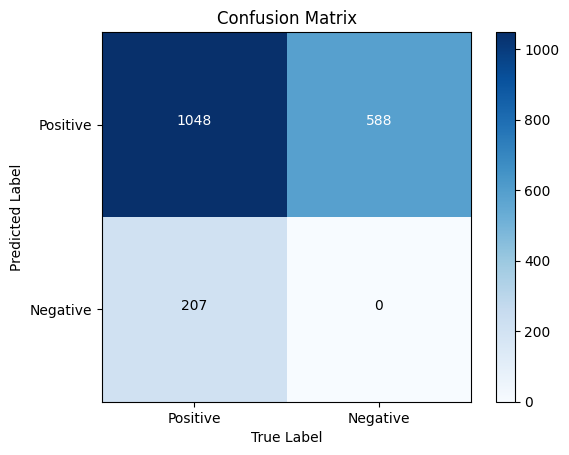

In [11]:
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = [0, 1]
plt.xticks(tick_marks, ['Positive', 'Negative'])
plt.yticks(tick_marks, ['Positive', 'Negative'])
plt.ylabel('Predicted Label')
plt.xlabel('True Label')
for i in range(2):
    for j in range(2):
        plt.text(j, i, confusion_matrix[i][j], horizontalalignment="center", color="white" if confusion_matrix[i][j] > 210 else "black")


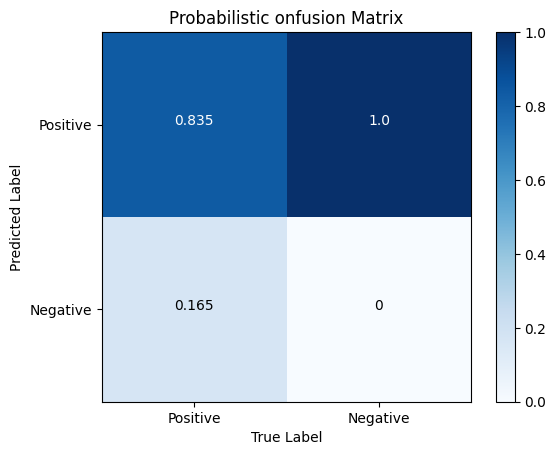

In [12]:
total_annotations = tp + fn
probabilistic_confusion_matrix = [[round(tp/total_annotations,3), fp/fp],[round(fn/total_annotations,3), 0]]

plt.imshow(probabilistic_confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Probabilistic onfusion Matrix')
plt.colorbar()
tick_marks = [0, 1]
plt.xticks(tick_marks, ['Positive', 'Negative'])
plt.yticks(tick_marks, ['Positive', 'Negative'])
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
for i in range(2):
    for j in range(2):
        plt.text(j, i, probabilistic_confusion_matrix[i][j], horizontalalignment="center", color="white" if probabilistic_confusion_matrix[i][j] > 0.5 else "black")


# Bounding box variation

In [13]:
def compute_bbox_errors(ground_truth_bbox, predicted_bbox):
    # Compute center point of ground truth and predicted bounding boxes
    gt_center_x, gt_center_y = (ground_truth_bbox['x1'] + ground_truth_bbox['x2'])/2, (ground_truth_bbox['y1'] + ground_truth_bbox['y2'])/2
    pred_center_x, pred_center_y = (predicted_bbox['x1'] + predicted_bbox['x2'])/2, (predicted_bbox['y1'] + predicted_bbox['y2'])/2
    
    # Compute width and height of ground truth and predicted bounding boxes
    gt_width, gt_height = ground_truth_bbox['x2'] - ground_truth_bbox['x1'], ground_truth_bbox['y2'] - ground_truth_bbox['y1']
    pred_width, pred_height = predicted_bbox['x2'] - predicted_bbox['x1'], predicted_bbox['y2'] - predicted_bbox['y1']
    
    # Compute error vectors between ground truth and predicted bounding boxes
    cx_error = gt_center_x - pred_center_x
    cy_error = gt_center_y - pred_center_y
    width_error = gt_width - pred_width
    height_error = gt_height - pred_height
    
    return [cx_error, cy_error, width_error, height_error]

In [14]:
bbox_error_vectors = []
for image, annots in ground_truth_annots.items():
    if image in predicted_detections.keys():
        for gt_annot in annots:
            for detection in predicted_detections[image]:
                iou = compute_iou(gt_annot, detection)
                if iou > iou_treshold:
                    error_vector = compute_bbox_errors(gt_annot, detection)
                    bbox_error_vectors.append(error_vector)

In [15]:
cx_e = [x[0] for x in bbox_error_vectors]
cy_e = [x[1] for x in bbox_error_vectors]
width_e = [x[2] for x in bbox_error_vectors]
height_e = [x[3] for x in bbox_error_vectors]


In [16]:
def calculate_varinace(numbers):
    # Step 1: Calculate the expected value
    expected_value = sum(numbers) / len(numbers)
    #expected_value = 0


    # Step 2: Subtract the expected value
    differences = [elem - expected_value for elem in numbers]

    # Step 3: Square the differences
    squared_differences = [diff**2 for diff in differences]

    # Step 4: Calculate the sum of squared differences
    sum_squared_diff = sum(squared_differences)

    # Step 5: Divide by the number of elements to get the variance
    variance = sum_squared_diff / len(numbers)


    print("Expected value:", expected_value)
    print("Variance:", variance)

    return expected_value, variance



In [17]:
print('IoU threshold: ', iou_treshold)
print('Error of center x')
cx_expected_value, cx_variance = calculate_varinace(cx_e)
print('\nError of center y')
cy_expected_value, cy_variance = calculate_varinace(cy_e)
print('\nError of width')
width_expected_value, width_variance = calculate_varinace(width_e)
print('\nError of height')
height_expected_value, height_variance = calculate_varinace(height_e)


IoU threshold:  0.5
Error of center x
Expected value: -0.012104283054003724
Variance: 14.941659817802892

Error of center y
Expected value: -1.2825884543761639
Variance: 42.94598175428014

Error of width
Expected value: 1.2439478584729982
Variance: 89.8436551779141

Error of height
Expected value: 2.323091247672253
Variance: 252.4384425857132


# Metrics vs time

In [18]:
image

'00000185'

In [44]:
def dropout_per_image(ground_truth_annots, predicted_detections, iou_threshold):
    # Compute the number of true positives, false positives, and false negatives
    dropout_images = {}
    fn = 0
    for image, gt_annotations in ground_truth_annots.items():
        fn = 0
        for gt_annot in gt_annotations:
            found_match = False
            if image in predicted_detections.keys():
                for pred_annot in predicted_detections[image]:
                    iou = compute_iou(gt_annot, pred_annot)
                    if iou > iou_threshold:
                        found_match = True
                        break
            if not found_match:
                fn += 1
        dropout_images[int(image)] = fn/len(gt_annotations)
        
    return dropout_images

In [45]:
dropout_images = dropout_per_image(ground_truth_annots, predicted_detections, iou_treshold)

In [46]:
sorted_image_numbers = list(dropout_images.keys())
sorted_image_numbers.sort()
sorted_dropout = [dropout_images[image_number] for image_number in sorted_image_numbers]

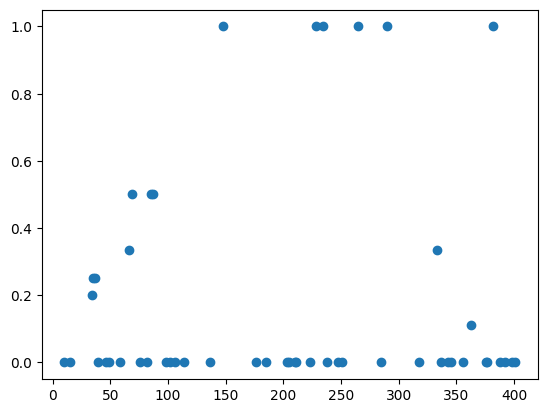

In [51]:
plt.plot(sorted_image_numbers[:50], sorted_dropout[:50], 'o')

In [ ]:
def clutter_per_image(ground_truth_annots, predicted_detections, iou_threshold):
    # Compute the number of true positives, false positives, and false negatives
    dropout_images = {}
    fn = 0
    for image, gt_annotations in ground_truth_annots.items():
        fn = 0
        for gt_annot in gt_annotations:
            found_match = False
            if image in predicted_detections.keys():
                for pred_annot in predicted_detections[image]:
                    iou = compute_iou(gt_annot, pred_annot)
                    if iou > iou_threshold:
                        found_match = True
                        break
            if not found_match:
                fn += 1
        dropout_images[int(image)] = fn/len(gt_annotations)
        
    return dropout_images